In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from collections import defaultdict
import re
from transformers import pipeline
from collections import Counter
from tqdm import tqdm
from razdel import sentenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andraf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


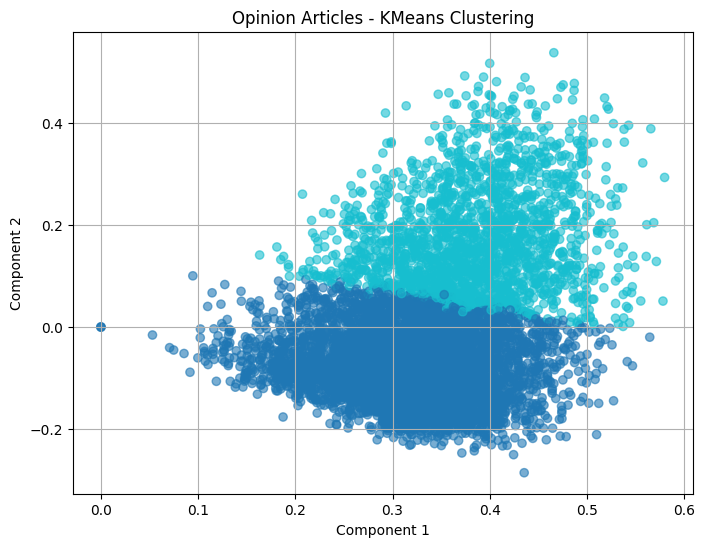

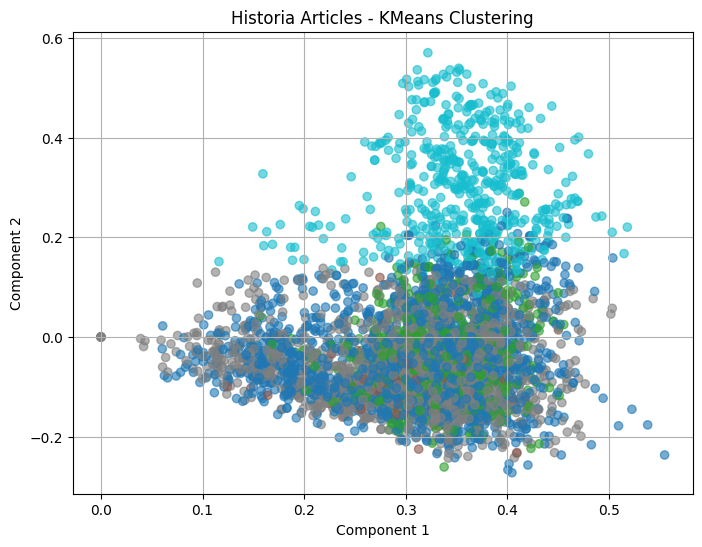

In [4]:
data_opinion = pd.read_json("data_cleaned_opinion.json")
data_historia = pd.read_json("data_cleaned_historia.json")
data_opinion['date_parsed'] = pd.to_datetime(data_opinion['date_parsed'])
data_historia['date_parsed'] = pd.to_datetime(data_historia['date_parsed'])

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
custom_stopwords = {
    "это", "день", "году", "например", "ещё", "время", "года", "год", "лет", "назад",
    "один", "первый", "именно", "также", "другой", "сегодня", "весь", "свой", "более",
    "очень", "таким", "просто", "всё", "часть", "затем", "хотя", "однако", "поскольку",
    "поэтому", "вместе", "вскоре", "позже", "кроме", "несмотря", "практически", "вроде", "вообще",
    "точно", "вполне", "весьма", "наконец", "лишь", "уже", "ещё", "тоже", "далее",
    "который", "которая", "которые", "которого", "которую", "которым", "которых", "котором", "которой",
    "которых", "которыми", "которым", "которую", "которого", "которое", "которые", "которых",
    "тот", "та", "то", "те", "этот", "эта", "это", "эти", "свой", "своя", "своё", "свои",
    "стал", "стала", "стали", "становится", "становился", "будут", "своей",
    "получил", "получила", "получили", "оказался", "оказалась", "оказались", "мог", "могла", "могли",
    "имел", "имела", "имели", "имеет", "имеют", "должен", "должна", "должны", "является", "являлся",
    "сказал", "заявил", "писал", "говорит", "говорил", "сказала","её","несколько", "результате", 
    "правда", "жизни", "роли", "времени", "момент", "дело", "людей", "среди", "своих", "своего"
}
stop_words = stop_words.union(custom_stopwords)
stop_words = list(stop_words)


# Unsupervised clustering pipeline
def cluster_articles(data, n_clusters=5, title="Opinion"):
    # Step 1: Convert texts into TF-IDF vectors (bag-of-words with weighting)
    tfidf = TfidfVectorizer(max_features=1000, stop_words=stop_words)
    X = tfidf.fit_transform(data['full_text'].fillna(""))

    # Step 2: Dimensionality reduction for visualization (PCA-like)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_reduced = svd.fit_transform(X)

    # Step 3: Clustering with KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    # Add cluster labels to the DataFrame
    data['cluster'] = labels

    # Step 4: 2D visualization of clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.title(f"{title} Articles - KMeans Clustering")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

    return data

clustered_opinion = cluster_articles(data_opinion, n_clusters=2, title="Opinion")
clustered_historia = cluster_articles(data_historia, n_clusters=5, title="Historia")

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords

def optimal_kmeans(data, title="Corpus", k_range=range(2, 30)):
    tfidf = TfidfVectorizer(max_features=1000, stop_words=stop_words)
    X = tfidf.fit_transform(data['full_text'].fillna(""))

    svd = TruncatedSVD(n_components=2, random_state=42)
    X_reduced = svd.fit_transform(X)

    best_k, best_score = None, -1
    scores = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append((k, score))
        if score > best_score:
            best_k, best_score = k, score

    plt.figure(figsize=(8, 4))
    plt.plot([k for k, _ in scores], [s for _, s in scores], marker="o")
    plt.title(f"Silhouette Scores for {title}")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

    kmeans = KMeans(n_clusters=best_k, random_state=42)
    labels = kmeans.fit_predict(X)
    data['cluster'] = labels

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap="tab10", alpha=0.6)
    plt.title(f"{title} Articles - Optimal k={best_k} (Silhouette={best_score:.2f})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

    return data, best_k, best_score


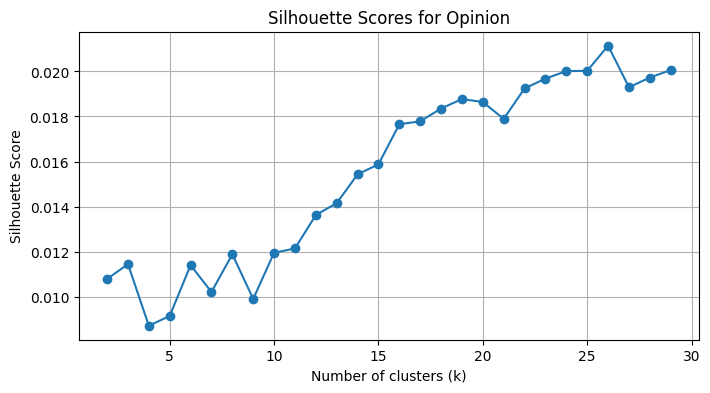

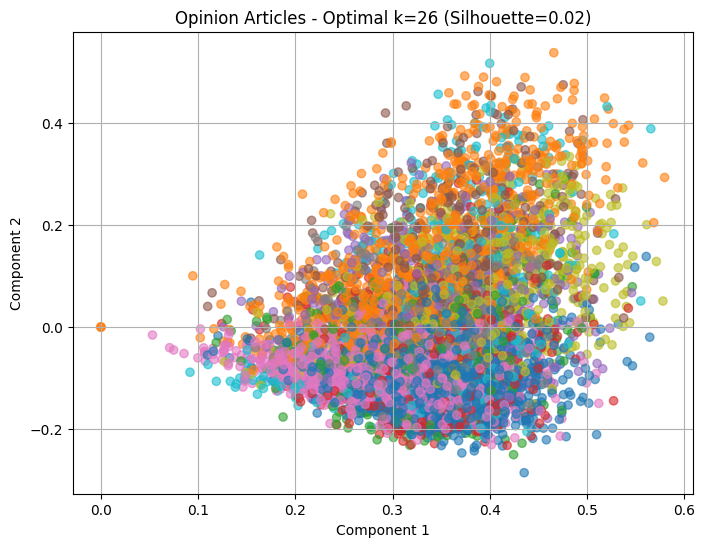

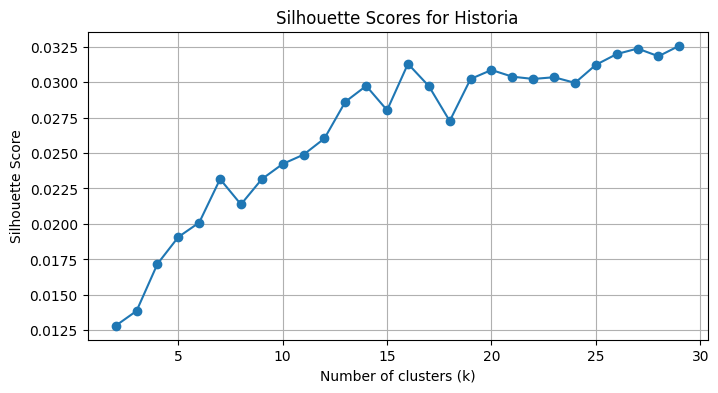

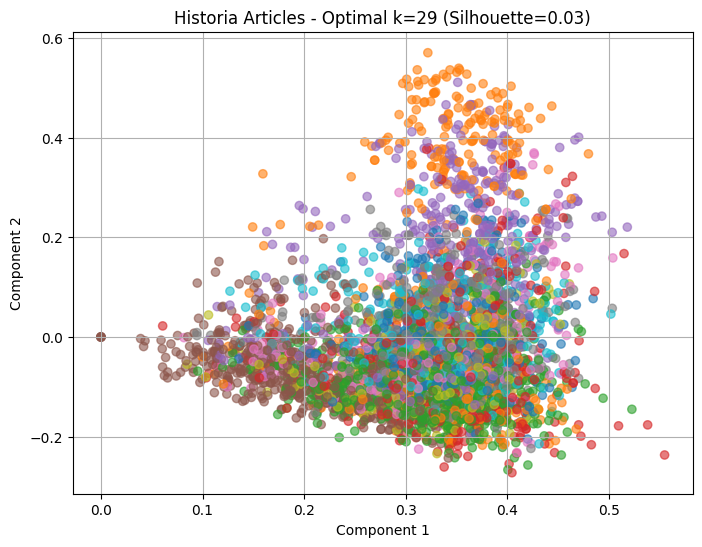

In [11]:
clustered_opinion, k_opinion, score_opinion = optimal_kmeans(data_opinion, title="Opinion")
clustered_historia, k_historia, score_historia = optimal_kmeans(data_historia, title="Historia")

In [2]:
extra_stopwords = {
    "украина", "украины", "украине", "украину", "украиной", "украиною",
    "украин", "украинец", "украинка", "украинцы",
    "украинский", "украинская", "украинское", "украинские", "украинских",
    "россия", "россии", "россию", "россией", "российская", "российский", "рф",
    "европа", "европы", "европе", "европу", "европой", "европейский",
    "сша", "америка", "америки", "американский"
    "страна", "государство", "регион", "город", "население", "система", "ситуация", "уровень",
    "есть", "был", "было", "будет", "быть", "делал", "делает", "делают", "делаем", 
    "можно", "нельзя", "должно", "нужно", "будто", "если", "тогда", "там", "здесь"
}
stop_words_v2 = list(set(stop_words).union(extra_stopwords))

# === TF-IDF + KMeans + Top Terms ===
def get_top_terms_per_cluster(tfidf_matrix, labels, feature_names, top_n=10):
    cluster_centers = []
    for cluster_id in np.unique(labels):
        cluster_docs = tfidf_matrix[labels == cluster_id]
        mean_tfidf = cluster_docs.mean(axis=0)
        cluster_centers.append(mean_tfidf)

    cluster_centers = np.vstack(cluster_centers)

    for idx, row in enumerate(cluster_centers):
        top_indices = np.argsort(row)[::-1][:top_n]
        top_terms = [feature_names[i] for i in top_indices]
        print(f"\nCluster {idx} top terms:")
        print(", ".join(top_terms))

# Vectorize texts (example: opinion articles)
tfidf = TfidfVectorizer(max_features=1000, stop_words=stop_words_v2)
X = tfidf.fit_transform(data_opinion['full_text'].fillna(""))

# Apply KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

# Extract top terms
get_top_terms_per_cluster(X.toarray(), labels, tfidf.get_feature_names_out(), top_n=15)


Cluster 0 top terms:
власти, люди, украинской, против, страны, человек, украинского, порошенко, тех, власть, украинцев, войны, нам, стране, пока

Cluster 1 top terms:
порошенко, зеленский, нато, ес, зеленского, президента, против, запад, войны, власти, президент, случае, страны, трампа, стороны


In [3]:
# Vectorize texts (example: opinion articles)
tfidf = TfidfVectorizer(max_features=1000, stop_words=stop_words)
X = tfidf.fit_transform(data_historia['full_text'].fillna(""))

# Apply KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# Extract top terms
get_top_terms_per_cluster(X.toarray(), labels, tfidf.get_feature_names_out(), top_n=15)


Cluster 0 top terms:
россии, империи, ii, казаков, войска, князь, посполитой, князя, русских, казаки, османской, короля, руси, речи, русские

Cluster 1 top terms:
армии, дивизии, го, фронта, немцы, генерал, противника, войска, танков, наступление, армия, войск, августа, 1943, районе

Cluster 2 top terms:
украины, ссср, сша, россии, украина, украине, войны, унр, республики, украинской, власти, украинского, против, усср, истории

Cluster 3 top terms:
оун, польши, упа, украинских, польской, польского, поляков, польше, польских, го, националистов, поляки, евреев, львове, украинской

Cluster 4 top terms:
фильм, булгаков, роль, фильма, ссср, фильме, булгакова, жизнь, киеве, войны, годы, отец, николай, александр, дом


C:\Users\Andraf\AppData\Local\Temp\ipykernel_8884\2268038963.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[cluster_id].set_xticklabels(author_counts.index, rotation=90)
C:\Users\Andraf\AppData\Local\Temp\ipykernel_8884\2268038963.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[cluster_id].set_xticklabels(author_counts.index, rotation=90)
C:\Users\Andraf\AppData\Local\Temp\ipykernel_8884\2268038963.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[cluster_id].set_xticklabels(author_counts.index, rotation=90)
C:\Users\Andraf\AppData\Local\Temp\ipykernel_8884\2268038963.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[cl

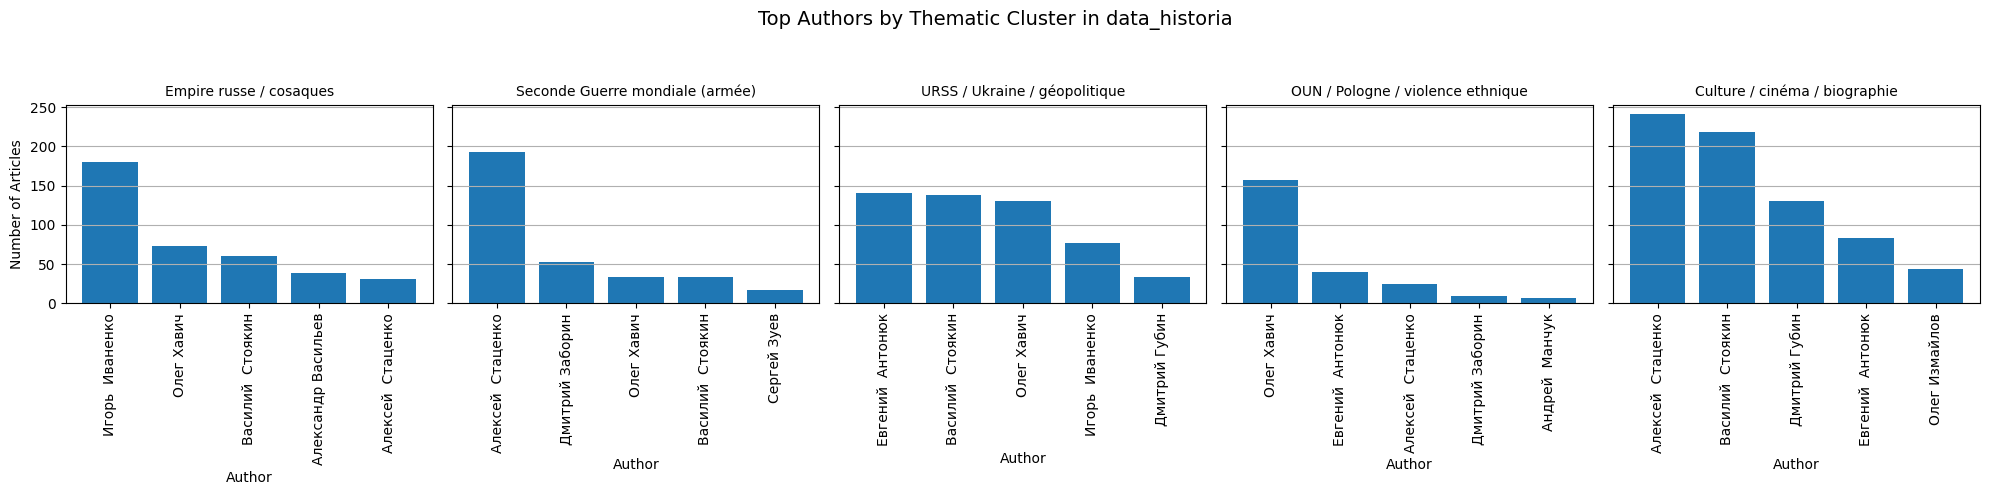

In [ ]:
n_clusters = 5
top_n = 5  # top auteurs par cluster

# Noms explicites des clusters
cluster_names = {
    0: "Empire russe / cosaques",
    1: "Seconde Guerre mondiale (armée)",
    2: "URSS / Ukraine / géopolitique",
    3: "OUN / Pologne / violence ethnique",
    4: "Culture / cinéma / biographie"
}

# Création des subplots
fig, axes = plt.subplots(1, n_clusters, figsize=(20, 5), sharey=True)

for cluster_id in range(n_clusters):
    # Sous-ensemble du cluster
    cluster_data = data_historia[data_historia['cluster'] == cluster_id]
    # Comptage des auteurs
    author_counts = cluster_data['author'].value_counts().head(top_n)
    # Plot
    axes[cluster_id].bar(author_counts.index, author_counts.values)
    axes[cluster_id].set_title(cluster_names[cluster_id], fontsize=10)
    axes[cluster_id].set_xticklabels(author_counts.index, rotation=90)
    axes[cluster_id].set_xlabel("Author")
    if cluster_id == 0:
        axes[cluster_id].set_ylabel("Number of Articles")
    axes[cluster_id].grid(axis='y')

plt.suptitle("Top Authors by Thematic Cluster in data_historia", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [ ]:
historia_3 = data_historia[data_historia['cluster'] == 3].copy()

pattern_poland = re.compile(r"\b(польша|поляков|польской|польского|польских|поляки|польше)\b", re.IGNORECASE)
rows = []
for _, row in historia_3.iterrows():
    for paragraph in row['full_text'].split('\n'):
        if len(paragraph.strip().split()) >= 5 and pattern_poland.search(paragraph):
            rows.append({
                'title': row['title'],
                'date': row['date_parsed'],
                'author': row['author'],
                'paragraph': paragraph.strip()
            })

df_poland_paragraphs = pd.DataFrame(rows)

clf = pipeline("zero-shot-classification", model="DeepPavlov/xlm-roberta-large-en-ru-mnli", device=0)

labels_russian = ["обвинительный", "жертвенный", "нейтрально-исторический", "современная полемика"]

def classify_paragraph(paragraph):
    result = clf(paragraph[:512], candidate_labels=labels_russian)
    return {
        "predicted_label": result['labels'][0],
        "scores": dict(zip(result['labels'], result['scores']))
    }

results = df_poland_paragraphs['paragraph'].apply(classify_paragraph)

df_poland_paragraphs['predicted_label'] = results.map(lambda x: x['predicted_label'])
df_poland_paragraphs['score_dict'] = results.map(lambda x: x['scores'])


config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

c:\Users\Andraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Andraf\.cache\huggingface\hub\models--DeepPavlov--xlm-roberta-large-en-ru-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/944k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


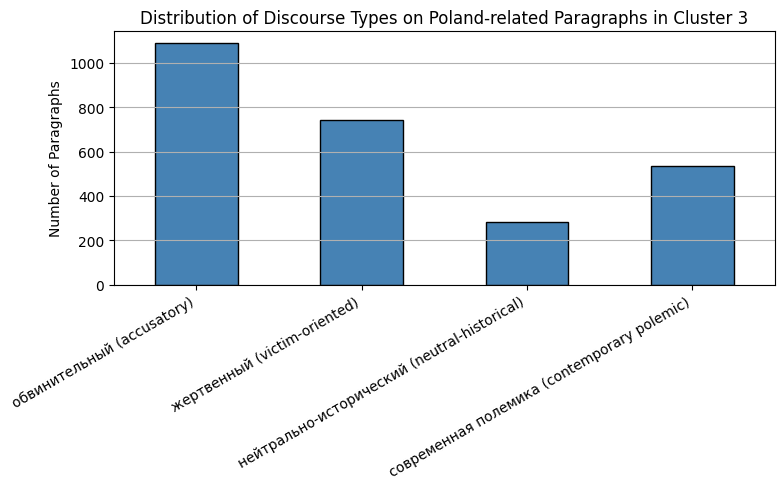

In [18]:
label_counts = df_poland_paragraphs['predicted_label'].value_counts()
label_counts = label_counts.reindex([
    "обвинительный", 
    "жертвенный", 
    "нейтрально-исторический", 
    "современная полемика"
])

label_translations = {
    "обвинительный": "обвинительный (accusatory)",
    "жертвенный": "жертвенный (victim-oriented)",
    "нейтрально-исторический": "нейтрально-исторический (neutral-historical)",
    "современная полемика": "современная полемика (contemporary polemic)"
}

label_counts.index = [label_translations[l] for l in label_counts.index]

plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribution of Discourse Types on Poland-related Paragraphs in Cluster 3')
plt.ylabel('Number of Paragraphs')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
pattern_poland = re.compile(r"\b(польша|поляков|польской|польского|польских|поляки|польше)\b", re.IGNORECASE)
rows = []
for _, row in data_historia.iterrows():
    for paragraph in row['full_text'].split('\n'):
        if len(paragraph.strip().split()) >= 5 and pattern_poland.search(paragraph):
            rows.append({
                'title': row['title'],
                'date': row['date_parsed'],
                'author': row['author'],
                'paragraph': paragraph.strip()
            })

df_poland_paragraphs_all = pd.DataFrame(rows)

clf = pipeline("zero-shot-classification", model="DeepPavlov/xlm-roberta-large-en-ru-mnli", device=0)

labels_russian = ["обвинительный", "жертвенный", "нейтрально-исторический", "современная полемика"]

def classify_paragraph(paragraph):
    result = clf(paragraph[:512], candidate_labels=labels_russian)
    return {
        "predicted_label": result['labels'][0],
        "scores": dict(zip(result['labels'], result['scores']))
    }

results = df_poland_paragraphs_all['paragraph'].apply(classify_paragraph)

df_poland_paragraphs_all['predicted_label'] = results.map(lambda x: x['predicted_label'])
df_poland_paragraphs_all['score_dict'] = results.map(lambda x: x['scores'])


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


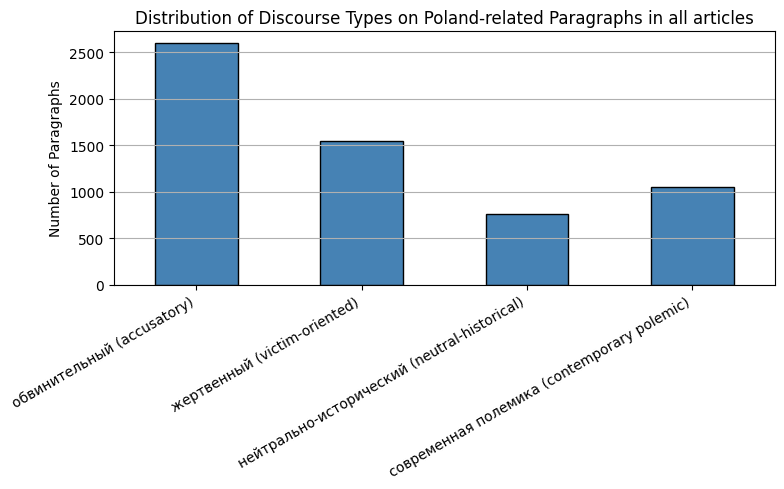

In [21]:
label_counts = df_poland_paragraphs_all['predicted_label'].value_counts()
label_counts = label_counts.reindex([
    "обвинительный", 
    "жертвенный", 
    "нейтрально-исторический", 
    "современная полемика"
])

label_translations = {
    "обвинительный": "обвинительный (accusatory)",
    "жертвенный": "жертвенный (victim-oriented)",
    "нейтрально-исторический": "нейтрально-исторический (neutral-historical)",
    "современная полемика": "современная полемика (contemporary polemic)"
}

label_counts.index = [label_translations[l] for l in label_counts.index]


plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribution of Discourse Types on Poland-related Paragraphs in all articles')
plt.ylabel('Number of Paragraphs')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

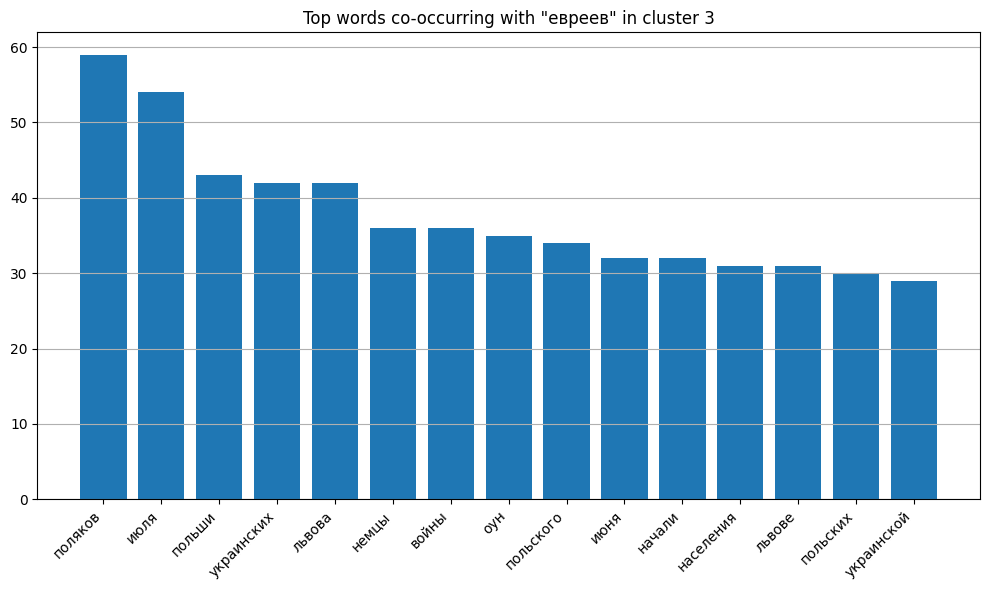

In [ ]:

# Sélection des paragraphes contenant "евреев"
pattern_jews = re.compile(r"\bевре(ев|и|ям|ями|ях)?\b", re.IGNORECASE)

jew_paragraphs = []
for _, row in historia_3.iterrows():
    for paragraph in row['full_text'].split('\n'):
        if pattern_jews.search(paragraph) and len(paragraph.strip().split()) >= 5:
            jew_paragraphs.append(paragraph.strip())

custom_stopwords_nationalist = {
    "еврей", "евреи", "евреев", "евреям", "евреями", "евреях", "тысяч", "человек", "около", "города", "жителей"
}
stop_words_nationalist = list(set(stop_words).union(custom_stopwords_nationalist))
stop_words_nationaist = list(stop_words)


words = []
for para in jew_paragraphs:
    tokens = re.findall(r'\b[а-яА-ЯёЁ]{3,}\b', para.lower())
    words.extend(tokens)

filtered_words = [w for w in words if w not in stop_words_nationalist and not w.isdigit()]
counter = Counter(filtered_words)
top_words = counter.most_common(15)

# Visualisation (bar plot)
import matplotlib.pyplot as plt

labels, values = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.title('Top words co-occurring with "евреев" in cluster 3')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# pipeline de sentiment
sentiment_model = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

# top mots sans "евреев"
top_terms = [w for w, _ in counter.most_common(20) if w not in custom_stopwords_nationalist]

# dictionnaire : mot → liste des scores de sentiment de ses paragraphes
sentiment_per_word = defaultdict(list)

for term in top_terms:
    for para in jew_paragraphs:
        if term in para.lower():
            result = sentiment_model(para[:512])[0]
            score = result['score']
            label = result['label']
            # Convention : NEGATIVE → score -1, NEUTRAL → 0, POSITIVE → +1
            polarity = {
                "NEGATIVE": -score,
                "NEUTRAL": 0,
                "POSITIVE": score
            }.get(label, 0)
            sentiment_per_word[term].append(polarity)


Device set to use cuda:0


C:\Users\Andraf\AppData\Local\Temp\ipykernel_27040\3479203903.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(terms, rotation=45, ha='right')


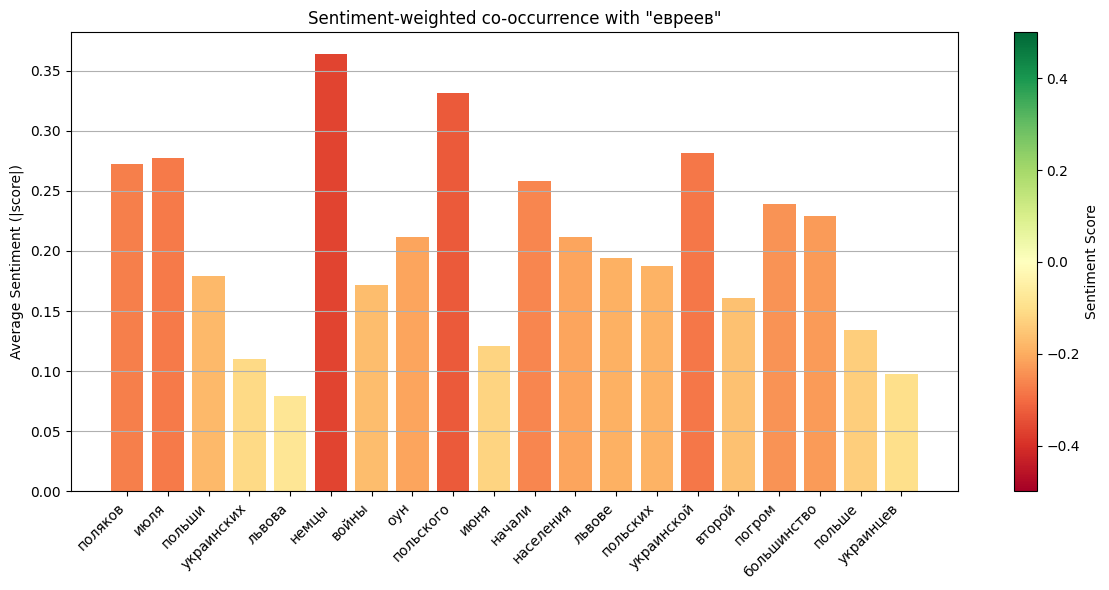

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize

terms = list(avg_sentiment.keys())
scores = np.array([avg_sentiment[t] for t in terms])

# Normalize color scale with tighter bounds around 0
norm = Normalize(vmin=-0.5, vmax=0.5)
colors = cm.RdYlGn(norm(scores))
sm = cm.ScalarMappable(norm=norm, cmap='RdYlGn')

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(terms, np.abs(scores), color=colors)

ax.set_title('Sentiment-weighted co-occurrence with "евреев"')
ax.set_ylabel("Average Sentiment (|score|)")
ax.set_xticklabels(terms, rotation=45, ha='right')
ax.grid(axis='y')

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Sentiment Score")

plt.tight_layout()
plt.show()

In [8]:
historia_films = data_historia[data_historia['cluster'] == 4].copy()

stop_words_film = list(set(stop_words).union({
    "фильм", "фильма", "фильме", "фильмы", "фильмам", "фильмами", 
    "сериал", "сериала", "сериале", "сериалы", "сериалам", "сериалами", 
    "кино", "сценарий", "киностудии", "студии", "снимали", "снимать", "съёмок", "фильмов",
    "актёр", "актёра", "актёре", "актёры", "актёрам", "актёрами",
    "режиссёр", "режиссёра", "режиссёре", "режиссёры", "режиссёрам", "режиссёрами",
    "сыграл", "снял", "снять", "главную", "роль", "героя", "герои", "актёров", "зрителей", "съёмки", "съёмочной", "картины",

    # Connecteurs ou adverbes
    "кстати", "действительно", "удалось"
}))
# Vectorize with updated stopwords
tfidf_film = TfidfVectorizer(max_features=1000, stop_words=stop_words_film)
X_film = tfidf_film.fit_transform(historia_films['full_text'].fillna(""))

# New clustering (adjust n_clusters as needed)
kmeans_film = KMeans(n_clusters=5, random_state=42)
labels_film = kmeans_film.fit_predict(X_film)

# Attach new cluster labels to DataFrame
historia_films['subcluster'] = labels_film

# Display top terms per subcluster
get_top_terms_per_cluster(
    X_film.toarray(), 
    labels_film, 
    tfidf_film.get_feature_names_out(), 
    top_n=15
)


Cluster 0 top terms:
иешуа, мастера, маргарита, мастер, маргариты, булгаков, романе, романа, скорее, булгакова, имя, роман, внимание, случае, версии

Cluster 1 top terms:
памятник, киеве, николай, россии, университета, шевченко, русской, дом, киев, губернии, александр, академии, церкви, русского, истории

Cluster 2 top terms:
булгаков, булгакова, турбиных, белой, романа, пьесе, романе, гвардии, пьесы, сталин, дом, причём, михаил, писателя, почему

Cluster 3 top terms:
ссср, войны, завод, годы, ленина, город, человек, цк, завода, го, россии, города, партии, жизнь, советской

Cluster 4 top terms:
довженко, театра, ссср, режиссер, театр, войны, советского, фильмах, написал, фильму, пришлось, сцене, одесской, кадре, жизнь


In [ ]:
clf = pipeline("zero-shot-classification", model="DeepPavlov/xlm-roberta-large-en-ru-mnli", device=0)
labels_russian = ["обвинительный", "жертвенный", "нейтрально-исторический", "современная полемика"]

def classify_paragraphs_about(term, data, min_words=5, max_len=512, uncertainty_threshold=0.4):
    pattern = re.compile(rf"\b{term}\w*\b", re.IGNORECASE)
    rows = []
    for _, row in data.iterrows():
        for paragraph in row['full_text'].split('\n'):
            if len(paragraph.strip().split()) >= min_words and pattern.search(paragraph):
                rows.append({
                    'title': row['title'],
                    'date': row['date_parsed'],
                    'author': row['author'],
                    'paragraph': paragraph.strip()
                })

    df = pd.DataFrame(rows)

    def classify(text):
        result = clf(text[:max_len], candidate_labels=labels_russian)
        scores = dict(zip(result['labels'], result['scores']))
        top_label = result['labels'][0]
        top_score = result['scores'][0]
        is_uncertain = top_score < uncertainty_threshold
        return {
            'predicted_label': top_label,
            'score_dict': scores,
            'uncertain': is_uncertain
        }

    results = df['paragraph'].apply(classify)
    df['predicted_label'] = results.map(lambda x: x['predicted_label'])
    df['score_dict'] = results.map(lambda x: x['score_dict'])
    df['uncertain'] = results.map(lambda x: x['uncertain'])
    return df


def plot_label_distribution(df, title):
    label_order = [
        "обвинительный", 
        "жертвенный", 
        "нейтрально-исторический", 
        "современная полемика"
    ]
    label_translations = {
        "обвинительный": "обвинительный (accusatory)",
        "жертвенный": "жертвенный (victim-oriented)",
        "нейтрально-исторический": "нейтрально-исторический (neutral-historical)",
        "современная полемика": "современная полемика (contemporary polemic)"
    }

    label_counts = df['predicted_label'].value_counts().reindex(label_order).fillna(0)
    label_counts.index = [label_translations[l] for l in label_counts.index]

    plt.figure(figsize=(8, 5))
    label_counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title(title)
    plt.ylabel('Number of Paragraphs')
    plt.xticks(rotation=30, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


Device set to use cuda:0


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


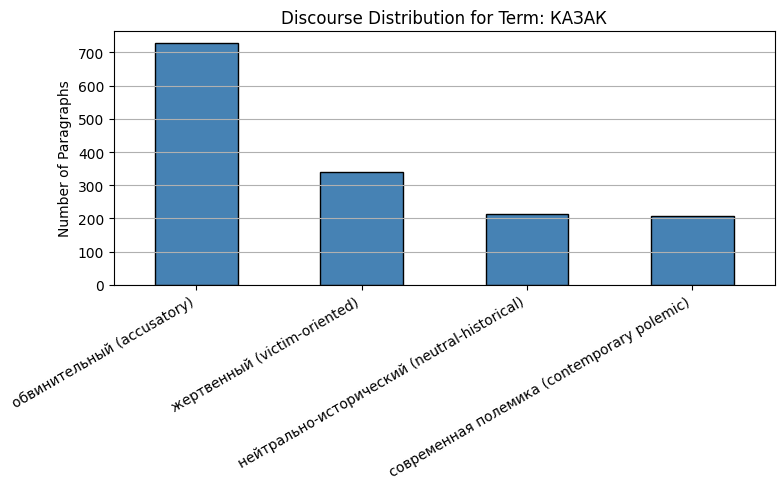

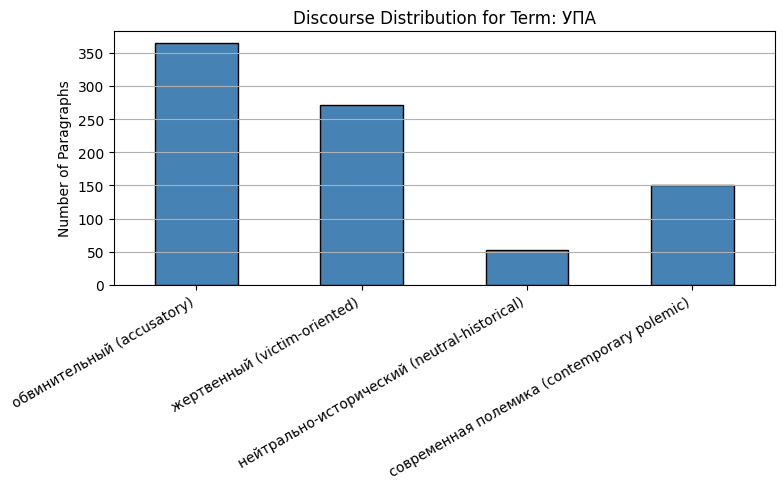

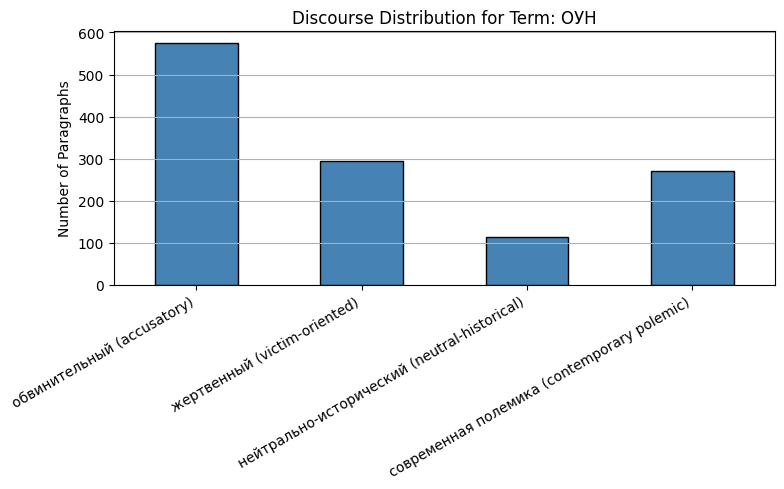

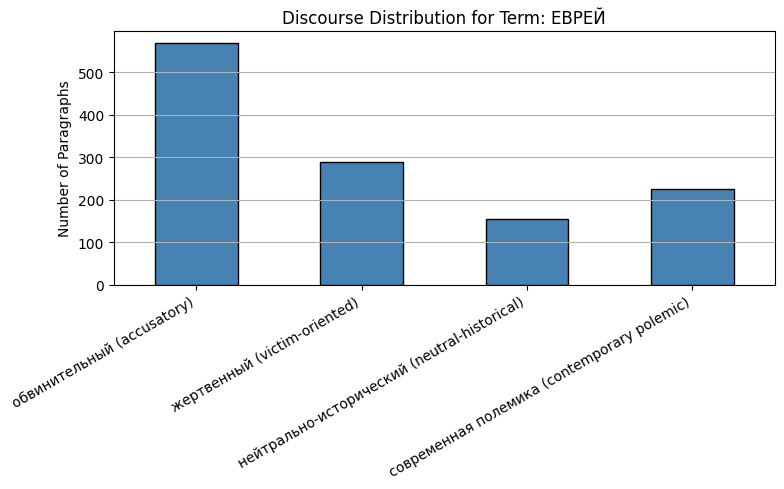

In [23]:
# Définition des motifs avec déclinaisons communes
terms_patterns = {
    "казак": r"\bказак(и|ов|ами|ах|у|ом)?\b",
    "упа": r"\bупа\b",
    "оун": r"\bоун\b",
    "еврей": r"\bевре(й|ев|ю|ем|и|ям|ями|ях)?\b"
}

results_by_term = {}

for term, pattern in terms_patterns.items():
    df_term = classify_paragraphs_about(pattern, data_historia)
    results_by_term[term] = df_term
    plot_label_distribution(df_term, f"Discourse Distribution for Term: {term.upper()}")
